According to the World Health Organization (WHO), 15 million people worldwide suffer a stroke annually, and  stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths. In South Africa, 10 people have strokes every hour [(Heart and Stroke Foundation South Africa (HSFSA))](https://www.heartfoundation.co.za/wp-content/uploads/2017/10/CVD-Stats-Reference-Document-2016-FOR-MEDIA-1.pdf).

This analysis is done to predict the likelihood of individuals getting stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relevant information about the patient.

#### Loading modules and packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### Evaluation and Modeling Libraries ####
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

#### Classification Model Libraries ####
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#### Metric Evaluation Libraries ####
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, precision_score, f1_score, accuracy_score

## Predictive Modeling Selection

In [2]:
def new_data():

    # Read in the data
    df_stroke = pd.read_csv('healthcare-dataset-stroke-data.csv')

    # Dropping unnecessary column: `id`
    df_stroke = df_stroke.drop(['id'], axis = 1)

    # Dropping rows with missing values
    df_stroke = df_stroke.dropna(subset = ['bmi'])

    # One Hot Encoding the categorical variables
    df_stroke['gender'] = df_stroke['gender'].astype('category').cat.codes
    df_stroke['ever_married'] = df_stroke['ever_married'].astype('category').cat.codes
    df_stroke['work_type'] = df_stroke['work_type'].astype('category').cat.codes
    df_stroke['Residence_type'] = df_stroke['Residence_type'].astype('category').cat.codes
    df_stroke['smoking_status'] = df_stroke['smoking_status'].astype('category').cat.codes

    # Splitting the data into X and y
    y = df_stroke['stroke']
    X = df_stroke.drop(['stroke'], axis=1)

    return X, y, df_stroke

### Raw Data

In [3]:
def raw_data():
    X, y, df_stroke = new_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
    return X_train, X_test, y_train, y_test

In [4]:
X_train, X_test, y_train, y_test = raw_data()

X_train.shape

(3681, 10)

### Functions utilized for evaluations:

In [5]:
#### Function for cross validation score ####

def evaluate_model(X, y, model):
   cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 42)
   scores = cross_val_score(model, X, y, scoring = 'roc_auc', cv = cv, n_jobs = -1)
   return scores

In [6]:
#### Function for getting Accuracy, Precision, F1-score, and Recall ####

def evaluate_scores(y_test, y_pred):
    
    print('Accuracy Score : ' + str(accuracy_score(y_test, y_pred)))
    print('Precision Score : ' + str(precision_score(y_test, y_pred)))
    print('Recall Score : ' + str(recall_score(y_test, y_pred)))
    print('F1 Score : ' + str(f1_score(y_test, y_pred)))
    print()

In [7]:
#### Function for Confusion Matrix ####

def plot_confusion_matrix(matrix):
    
    # Confusion matrix for binary data
    tags = ['TP', 'FP', 'FN', 'TN']
    labels = [f'{tag}\n{value}' for tag, value in zip(tags, matrix.ravel())]
    labels = np.asarray(labels).reshape(2,2)

    # Using Heatmap from Seaborn to create confusion matrix
    fig, ax = plt.subplots(1, 1, figsize = (8, 8), facecolor = '#fbfbfb')
    sns.heatmap(matrix, annot=labels, cmap='Blues', fmt='')
    plt.title("Confusion Matrix", fontsize=15)
    plt.xlabel('Predicted', fontsize=10)
    plt.ylabel('Original', fontsize=10)
    
    ax.set_facecolor("#fbfbfb")
    
    plt.show()

### Baseline Model (Dummy Classifier)

In [8]:
#### Initiating the Dummy Classifier:

X_train, X_test, y_train, y_test = raw_data()

pipeline_dumb = Pipeline(steps=[('scale', StandardScaler()), ('model', DummyClassifier(strategy= 'most_frequent'))])
y_pred_dumb = pipeline_dumb.fit(X_train, y_train).predict(X_test)

# Distribution of y test
print('y actual : \n' +  str(y_test.value_counts()))
print()

# Distribution of y predicted
print('y predicted : \n' + str(pd.Series(y_pred_dumb).value_counts()))
print()


y actual : 
stroke
0    1165
1      63
Name: count, dtype: int64

y predicted : 
0    1228
Name: count, dtype: int64



>ROC AUC Score of Dummy Clasifier: 0.500 (0.000)



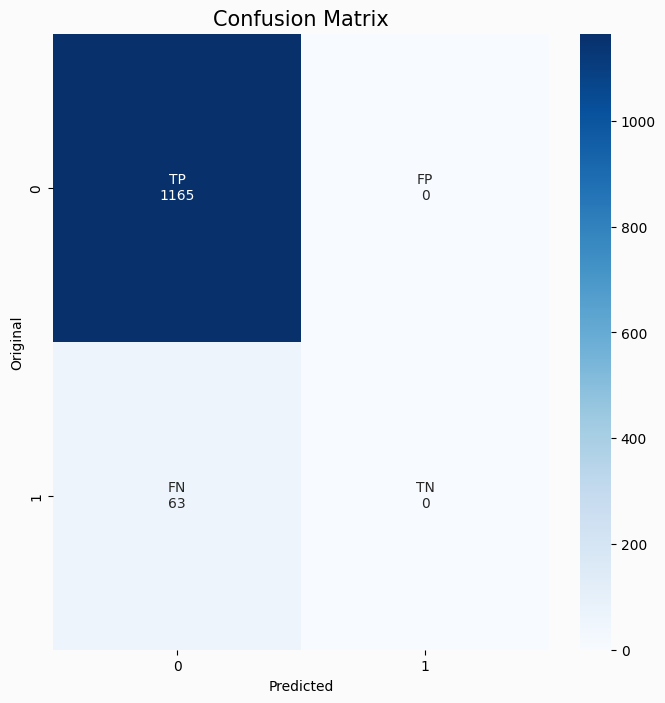

In [9]:
#### Evaluating the dummy model
model_evaluated = evaluate_model(X_train, y_train, pipeline_dumb)
print('>%s %.3f (%.3f)' % ('ROC AUC Score of Dummy Clasifier:', np.mean(model_evaluated), np.std(model_evaluated)))
print()

# # Evaluation metrics:
# evaluate_scores(y_test, y_pred_dumb)

# Confusion Matrixs
dummy_cm = confusion_matrix(y_test, y_pred_dumb)
plot_confusion_matrix(dummy_cm)

WHAT WE KNOW FROM Dummy Classifer:

1. From the output, we can observe that there are 53 FN(1) and 929 TP(0) cases in the test dataset. However, our classifier predicts all cases as TP (as it is the majority class).

2. ROC AUC score of 0.5 indicating for incapabilitiy of model's classification. The accuracy score is 0.490. This is shown by the confusion matrix diagram where it does not classify any malignant case (TP) correctly,

3. Above Confusion Matrix shows that:
    - TRUE POSITIVES (TP) = 929,
    - TRUE NEGATIVES (TN) = 0, 
    - FALSE POSITIVES (FP) = 0, 
    - FALSE NEGATIVES (FN)= 53

#### 2. Now we know the baseline accuracy, we build our actual models with default parameters, then evaluate the model

In [10]:
### Classifier Models ###

classifier_models = {
    'Log-Reg' : LogisticRegression(solver = 'liblinear'),
    'K-Nearest' : KNeighborsClassifier(),
    'Dec-Tree' : DecisionTreeClassifier(),
    'Rand-For' : RandomForestClassifier(),
    'SVM' : SVC(gamma='scale')
}

In [11]:
results = list()

for names, clf in classifier_models.items():

    X_train, X_test, y_train, y_test = raw_data()

    # Create a pipeline that first scales the data then fits the classifier model
    pipeline = Pipeline(steps=[('scale', StandardScaler()), ('model', clf)])
    y_pred = pipeline.fit(X_train, y_train).predict(X_test)
    
    # Evaluate the model using a cross validated ROC AUC score 
    scores = evaluate_model(X_train, y_train, pipeline)
    results.append(scores)

    # Print out the mean and standard deviation of the scores
    print('>%s: %.3f (%.3f)' % (names, np.mean(scores), np.std(scores)))
    # evaluate_scores(y_test, y_pred)
    print()

    # # Confusion Matrix for each models
    # cm_plot = confusion_matrix(y_test, y_pred)

>Log-Reg: 0.839 (0.044)

>K-Nearest: 0.585 (0.070)

>Dec-Tree: 0.542 (0.044)

>Rand-For: 0.787 (0.058)

>SVM: 0.579 (0.078)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


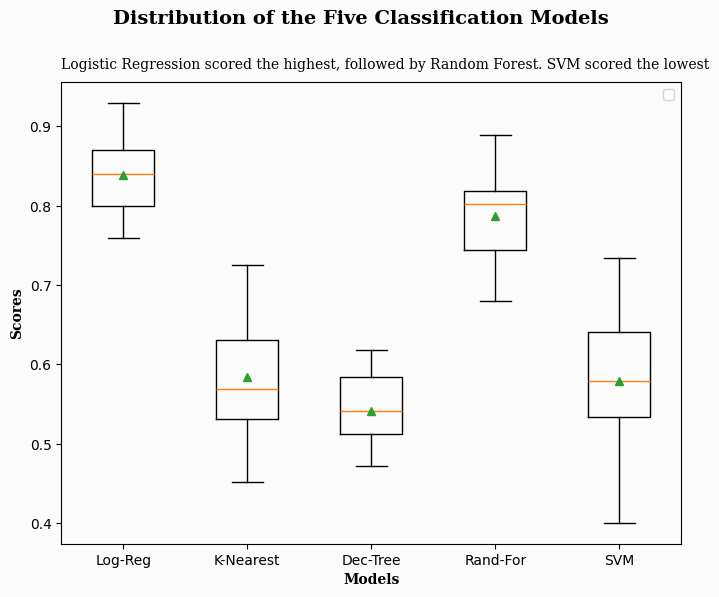

In [12]:
### Looking at the resulting score's distribution:

fig, ax = plt.subplots(1, 1, figsize=(8,6), facecolor = "#fbfbfb")

plt.boxplot(results, labels = classifier_models.keys(), showmeans=True)

#### Editing the graphs
plt.suptitle('Distribution of the Five Classification Models',
             y = 1.00, 
             fontfamily='serif', 
             fontsize=14, 
             fontweight='bold')
plt.title("Logistic Regression scored the highest, followed by Random Forest. SVM scored the lowest", 
          y = 1.01,
          fontfamily='serif', 
          fontsize=10, 
          fontweight='light',
          loc = 'left')

plt.xlabel('Models',
          fontfamily='serif', 
          fontsize=10, 
          fontweight='bold')
plt.ylabel('Scores',
          fontfamily='serif', 
          fontsize=10, 
          fontweight='bold')

ax.set_facecolor("#fbfbfb")
# ax.grid(which = 'major',
#         color = 'black', 
#         linestyle=':', 
#         axis='both', 
#         zorder=0,  
#         dashes=(1,5))

plt.legend()
plt.show()

#### Now since we know that our dataset is biased (Minority class of No Stroke), we use `SMOTE()` to upsample the minority class:

In [13]:
result_smote = list()

for names, clf in classifier_models.items():

    X_train, X_test, y_train, y_test = raw_data()

    # Create a pipeline (from imblearn package since SMOTE deal with the same package)
    pipeline = imbpipeline(steps = [('scale', StandardScaler()), ('over', SMOTE(random_state = 42)), ('model', clf)])
    y_pred = pipeline.fit(X_train, y_train).predict(X_test)

    # Evaluate the model using a cross validated ROC AUC score
    scores = evaluate_model(X_train, y_train, pipeline)
    result_smote.append(scores)

    # Print out the mean and standard deviation of the scores
    print('>%s: %.3f (%.3f)' % (names, np.mean(scores), np.std(scores)))
    # evaluate_scores(y_test, y_pred)
    print()

    # # Confusion Matrix for each models
    # cm_plot = confusion_matrix(y_test, y_pred)
    # plot_confusion_matrix(cm_plot)
    # print()

>Log-Reg: 0.834 (0.042)

>K-Nearest: 0.632 (0.078)

>Dec-Tree: 0.547 (0.043)

>Rand-For: 0.777 (0.055)

>SVM: 0.741 (0.051)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


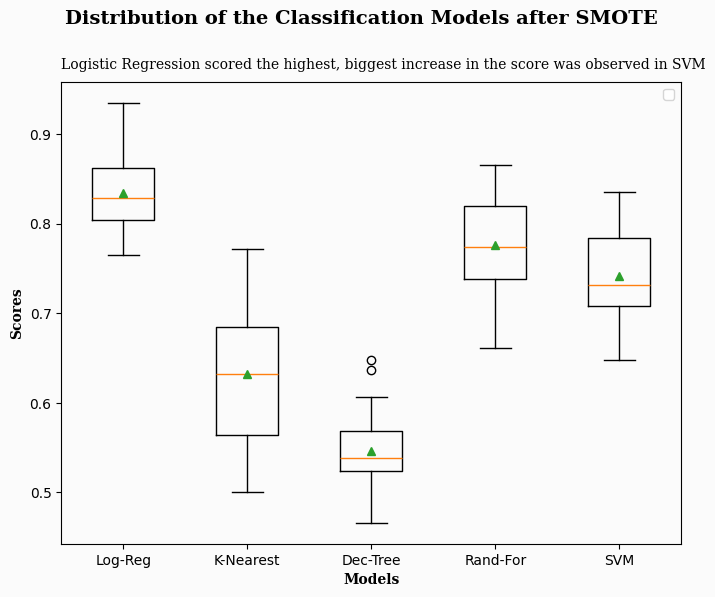

In [14]:
### Looking at the resulting score's distribution:

fig, ax = plt.subplots(1, 1, figsize=(8,6), facecolor = "#fbfbfb")

plt.boxplot(result_smote, labels = classifier_models.keys(), showmeans=True)

#### Editing the graphs
plt.suptitle('Distribution of the Classification Models after SMOTE',
             y = 1.00, 
             fontfamily='serif', 
             fontsize=14, 
             fontweight='bold')
plt.title("Logistic Regression scored the highest, biggest increase in the score was observed in SVM", 
          y = 1.01,
          fontfamily='serif', 
          fontsize=10, 
          fontweight='light',
          loc = 'left')

plt.xlabel('Models',
          fontfamily='serif', 
          fontsize=10, 
          fontweight='bold')
plt.ylabel('Scores',
          fontfamily='serif', 
          fontsize=10, 
          fontweight='bold')

ax.set(axisbelow = True)
ax.set_facecolor("#fbfbfb")
# ax.grid(which = 'major',
#         color = 'black', 
#         linestyle=':', 
#         axis='both', 
#         zorder=0,  
#         dashes=(1,5))

plt.legend()
plt.show()

WHAT WE FOUND OUT:

- When using **raw data**, the model performance are as follows: Logistic Regression > Random Forest > SVM > K-Nearest Neighbour > Decision Tree.
- When using **SMOTE data**, the model performance are as follows: Logistic Regression > Random Forest > SVM > K-Nearest Neighbour > Decision Tree.
    - Majority Class: No Stroke.
    - Minority Class: Yes Stroke.
    
    - SVM model had the higest mean ROC AUC score increase from 0.600 to 0.751. 
    - K-Nearest Neighbour had the second highest mean ROC AUC score increase from 0.597 to 0.637.
    - A marginal decrease in the mean score was observed in Logistic regression and Random Forest when SMOTE data was used, however, this is negligible. 

- Overall, the best performed model is = **Logistic Regression**. This model will be used downstream for the `stroke` prediction. 

#### Finalizing the Models for Stroke Prediction ####

1. initiate the dataset
2. Model initiation with pipeline with random state = 42
3. KFold initiation for evaluation
4. Hyperparameter tuning using Grid Search CV -> Find the best parameter
5. Refit the model using the best parameter


In [15]:
#### Logistic Regression Model ####

# Calling train and test splits:
X_train, X_test, y_train, y_test = raw_data()

# Create a pipeline (from imblearn package since SMOTE deal with the same package)
pipeline = imbpipeline(steps = [('scale', StandardScaler()), ('over', SMOTE(random_state = 42)), 
                                ('model', LogisticRegression(solver = 'liblinear', random_state = 42))])

# Model evaluation with Repeated Stratified Kfold:
repeat_strat_kfold = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 42)

# Parameter values:
params = {'model__penalty': ['l1', 'l2'],
          'model__C':[0.001, 0.01, 0.1, 5, 10, 100]}

# Grid Search CV for hyperparameter tuning:
grid = GridSearchCV(estimator = pipeline, 
                    param_grid = params, 
                    scoring = 'roc_auc', 
                    cv = repeat_strat_kfold, 
                    n_jobs = -1)

# Fit the model to the data
grid.fit(X_train, y_train)

# Getting the best parameter
print(grid.best_params_)

{'model__C': 0.01, 'model__penalty': 'l1'}


              precision    recall  f1-score   support

           0       0.99      0.71      0.83      1165
           1       0.14      0.86      0.24        63

    accuracy                           0.72      1228
   macro avg       0.56      0.78      0.53      1228
weighted avg       0.95      0.72      0.80      1228


Accuracy Score : 0.7198697068403909
Precision Score : 0.13881748071979436
Recall Score : 0.8571428571428571
F1 Score : 0.23893805309734514



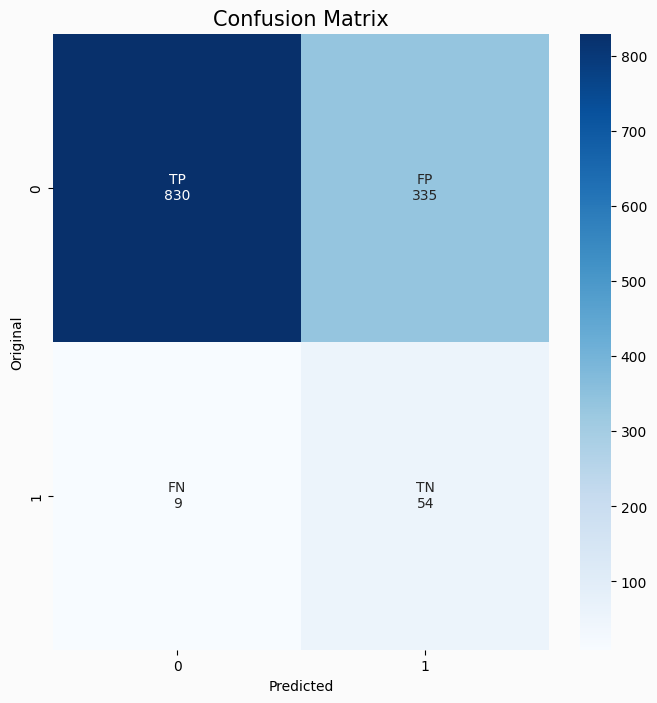

In [16]:
## Running the tuned model on the test data ## 

X_train, X_test, y_train, y_test = raw_data()

# Model initiation
log_reg_pipeline = imbpipeline(steps = [('scale', StandardScaler()), ('over', SMOTE(random_state = 42)), 
                                        ('model', LogisticRegression(solver = 'liblinear', 
                                                                     penalty = 'l1',
                                                                     C = 0.01, 
                                                                     random_state = 42))])

# Fitting the model
log_reg_pipeline.fit(X_train, y_train)

# Predicting the model with test data
log_reg_tuned_pred = log_reg_pipeline.predict(X_test)

# Printing the classification report:
print(classification_report(y_test, log_reg_tuned_pred))
print()

# New Model Evaluation metrics 
evaluate_scores(y_test, log_reg_tuned_pred)

# Calculate the values for each quadrant in the confusion matrix
cm = confusion_matrix(y_test, log_reg_tuned_pred)

# Create the confusion matrix as a visualization
plot_confusion_matrix(cm)

- TP (True Positive) = 711
- TN (True Negative) = 794
- FP (False Positive) = 211
- FN (False Negative) = 164


#### Modeling with Random Forest Classifier:

In [17]:
#### Random Forest Classifier Model ####

# Calling train and test splits:
X_train, X_test, y_train, y_test = raw_data()

# Create a pipeline (from imblearn package since SMOTE deal with the same package)
pipeline = imbpipeline(steps = [('scale', StandardScaler()), ('over', SMOTE(random_state = 42)), 
                                ('model', RandomForestClassifier(random_state=42))])

# Model evaluation with Repeated Stratified Kfold:# Model evaluation with Repeated Stratified Kfold:
repeat_strat_kfold = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 42)

# Parameter values:
params = {'model__n_estimators': [10, 50, 100, 200],
          'model__max_features': [2, 3, 5, 7],
          'model__bootstrap': [True, False]}

# Grid Search CV for hyperparameter tuning:
grid = GridSearchCV(estimator = pipeline, 
                    param_grid = params, 
                    scoring = 'roc_auc', 
                    cv = repeat_strat_kfold, 
                    n_jobs = -1)

# Fit the model to the data
grid.fit(X_train, y_train)

# Getting the best parameter
print(grid.best_params_)

{'model__bootstrap': True, 'model__max_features': 3, 'model__n_estimators': 200}


              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1165
           1       0.15      0.10      0.12        63

    accuracy                           0.93      1228
   macro avg       0.55      0.53      0.54      1228
weighted avg       0.91      0.93      0.92      1228


Accuracy Score : 0.9267100977198697
Precision Score : 0.15384615384615385
Recall Score : 0.09523809523809523
F1 Score : 0.11764705882352941



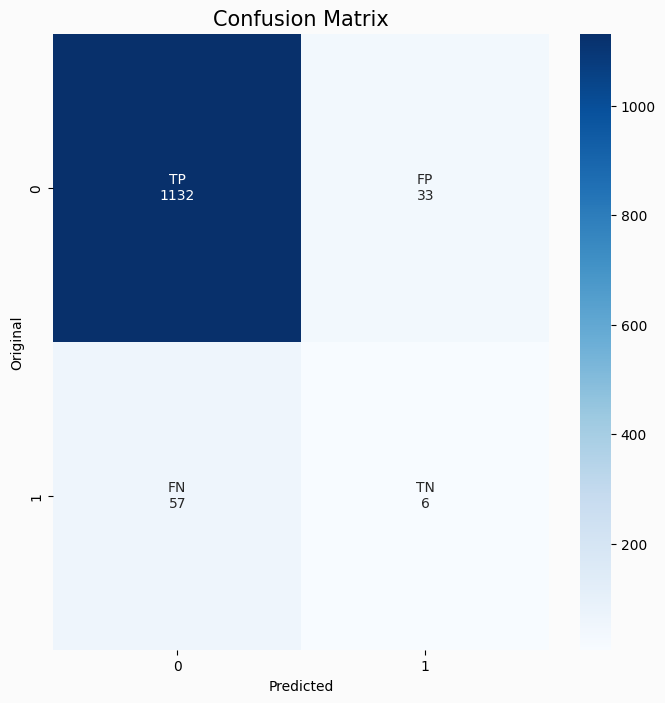

In [18]:
## Running the tuned model on the test data ## 

X_train, X_test, y_train, y_test = raw_data()

# Model initiation
rfc_pipeline = imbpipeline(steps = [('scale', StandardScaler()), ('over', SMOTE(random_state = 42)), 
                                    ('model', RandomForestClassifier(bootstrap = True, 
                                                                     max_features = 3, 
                                                                     n_estimators = 200,
                                                                     random_state = 42))])

# Fitting the model
rfc_pipeline.fit(X_train, y_train)

# Predicting the model with test data
rfc_tuned_pred = rfc_pipeline.predict(X_test)

# Printing the classification report:
print(classification_report(y_test, rfc_tuned_pred))
print()

# New Model Evaluation metrics 
evaluate_scores(y_test, rfc_tuned_pred)

# Calculate the values for each quadrant in the confusion matrix
cm = confusion_matrix(y_test, rfc_tuned_pred)

# Create the confusion matrix as a visualization
plot_confusion_matrix(cm)

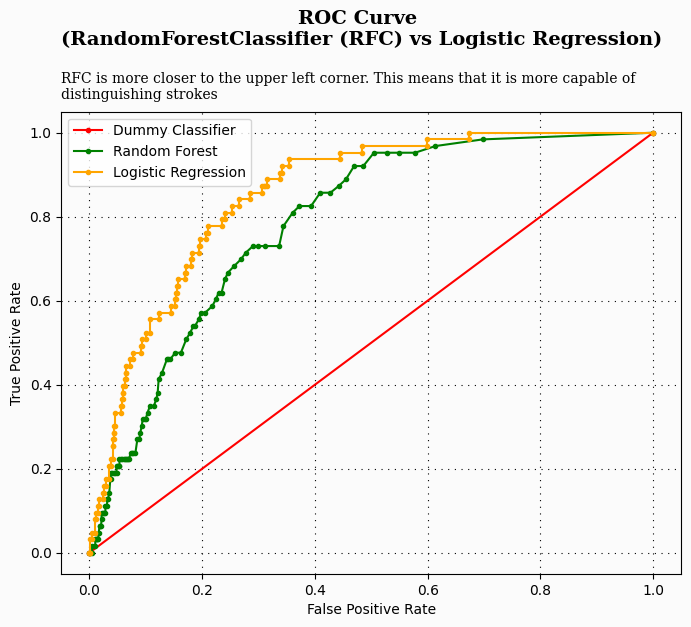

In [19]:
#### ROC AUC CURVE Plots of the Models ####

# Getting the curves for models:
pred_probab_dumb = pipeline_dumb.predict_proba(X_test)
pred_probab_rfc = pred_probab_dumb[: , 1]
fpr_dumb, tpr_dumb, _ = roc_curve(y_test, pred_probab_rfc)

pred_probab_rfc = rfc_pipeline.predict_proba(X_test)
pred_probab_rfc = pred_probab_rfc[: , 1]
fpr_rfc, tpr_rfc, _ = roc_curve(y_test, pred_probab_rfc)

pred_probab_log = log_reg_pipeline.predict_proba(X_test)
pred_probab_log = pred_probab_log[: , 1]
fpr_log, tpr_log, _ = roc_curve(y_test, pred_probab_log)

### Plotting graphs together
fig, ax = plt.subplots(1, 1, figsize=(8,6), facecolor = "#fbfbfb")

plt.plot(fpr_dumb, tpr_dumb, marker='.', color='Red', label='Dummy Classifier')
plt.plot(fpr_rfc, tpr_rfc, marker='.', color='green', label='Random Forest')
plt.plot(fpr_log, tpr_log, marker='.', color = 'orange', label='Logistic Regression')

#### Editing the graphs
plt.suptitle('ROC Curve \n(RandomForestClassifier (RFC) vs Logistic Regression)',
             y = 1.05, 
             fontfamily='serif', 
             fontsize=14, 
             fontweight='bold')
plt.title("RFC is more closer to the upper left corner. This means that it is more capable of \ndistinguishing strokes", 
          y = 1.01,
          fontfamily='serif', 
          fontsize=10, 
          fontweight='light',
          loc = 'left')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

ax.set(axisbelow = True)
ax.set_facecolor("#fbfbfb")
ax.grid(which = 'major',
        color = 'black', 
        linestyle=':', 
        axis='both', 
        zorder=0,  
        dashes=(1,5))

plt.legend()
plt.show()

#### Determining the most important features for the prediction: 

In [20]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'Feature':df.columns, 'Importance':m.feature_importances_}).sort_values('Importance', ascending=False)

X, y, df_stroke = new_data()
fi = rf_feat_importance(rfc_pipeline['model'], X)
fi[:10].style.background_gradient()

,Feature,Importance
1,age,0.337534
9,smoking_status,0.149191
7,avg_glucose_level,0.131985
8,bmi,0.111228
5,work_type,0.106419
4,ever_married,0.077910
6,Residence_type,0.024946
0,gender,0.024457
2,hypertension,0.021101
3,heart_disease,0.015231


## CONCLUSIONS:

- We've established a predictive modeling for the Stroke Dataset. 

- Owing to class imbalance between the majority (No Stroke) and minority class (Yes Stroke), we used SMOTE to oversample the minority class. 
    - This resulted in a increase in some model's performance (mainly the ROC AUC score). The increase was more prominent in the SVM model. 

- The best performing models are: Logistic Regression, followed by Random Forest. 

- Logistic Regression was able to predict with higher performance then Random Forest model. This was evident from the Precision and Recall score; and Logistic Regression's ability to predict with higher True Positives, and True Negatives.

- The most important feature for stroke estimation is Age. 

## Appendix Codes:

In [21]:
### Use this if you want to Impute missing values in the dataset with `median` values. 
### Since we removed the missing values, we will not be using this code...

# for i in range(len(models)):
#     transformer = ColumnTransformer(transformers = [('imp',SimpleImputer(strategy='median'),df_stroke_numerical),
#                                                     ('o', OneHotEncoder(), df_stroke_categorical)])
#     pipeline = Pipeline(steps=[('t', transformer),('p',PowerTransformer(method='yeo-johnson')),('m', models[i])])    
#     scores = evaluate_model(X, y, pipeline)
#     results.append(scores)
#     print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

In [22]:
## Another method to determine whether using SMOTE is good for Logistic Regression or not for the cross-validation and test scores. 

# def Modeling(X, y, smote = True):
    
#     # Train test splitting the data
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#     # IF-ELSE statement to determine whether to use SMOTE or not
#     if smote == True:
#         pipeline = imbpipeline(steps = [('scale', StandardScaler()), ('over', SMOTE(random_state=42)), ('model', LogisticRegression(solver = 'liblinear', 
#                                                                                                                                     random_state=42))])
#     else:
#         oversampling = SMOTE(random_state=42)
#         X_train, y_train = oversampling.fit_resample(X_train, y_train)
#         pipeline = Pipeline(steps = [('scale', StandardScaler()), ('model', LogisticRegression(solver = 'liblinear', 
#                                                                                                random_state=42))])

#     # Cross Validation using repeated stratified k fold
#     repeat_strat_kfold = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 42)

#     params = {'model__penalty': ['l1', 'l2'],
#               'model__C':[0.001, 0.01, 0.1, 5, 10, 100]}
    
#     # Grid Search
#     grid = GridSearchCV(estimator = pipeline,
#                         param_grid = params,
#                         scoring = 'roc_auc',
#                         cv = repeat_strat_kfold,
#                         n_jobs = -1)
    
#     grid.fit(X_train, y_train)
    
#     # Best parameters and their scores
#     cv_score = grid.best_score_
#     test_score = grid.score(X_test, y_test)
#     return (f"Cross-validation score: {cv_score} \n Test Score: {test_score}")

In [23]:
# X, y, df_stroke = new_data()

# model_smote_in_pipeline = Modeling(X, y, smote=True)
# model_smote_out_pipeline = Modeling(X, y, smote=False)

# print('Smote in the Pipeline: \n', model_smote_in_pipeline)
# print()
# print('Smote out of the Pipeline: \n',model_smote_out_pipeline)

In [24]:
# ### Visuals of the most important features

# feature_importance = pd.Series(RandomForestClassifier().feature_importances_, index = X.columns)
# feature_importance.nlargest(20).plot(kind = 'barh',title = 'Feature Importance')